In [1]:
import sys
sys.path.append("../src")
import jax
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(200)
import jax.numpy as jnp
from nn import MLP, train
import numpy as np
import matplotlib.pyplot as plt
import optax 
import scipy
from functools import partial
from path_sampling import dfdt, div_f, update_non_amortized
from path_sampling import make_double_well_potential, sample_sde


We now define a function that generates random paths given a drift term `b` and a noise term `W`:

## Example of Algorithm 1: with $b$ as Brownian drift


SPDE switched off currently, i.e. `refine=False` (but in the past I had it working with SPDE on)

In [2]:
potential = make_double_well_potential(v=5.0)

def uref(x, t): 
    return -jax.grad(potential)(x)


s:  0.0
Train loss: 4193483.25
s:  0.1
Train loss: 11.851068496704102
s:  0.5
Train loss: 12.207196235656738


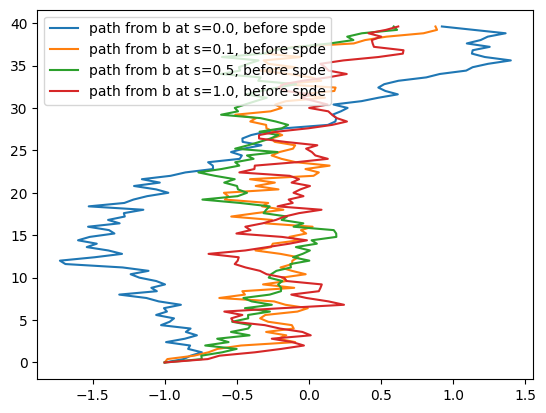

In [ ]:
# key = jax.random.key(0)

hyperparams = {'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 1000, 'batch_size' :200}

brownian_bridge_drift = lambda x,t: (1 - x)/(1-t)

ndims = 1

def make_J_brownian_bridge(dt, V):
    def J_brownian_bridge(x, y):
        nabla_V = jax.grad(V)
        laplacian_of_potential = jax.vmap(lambda k: jnp.trace(jax.jacfwd(nabla_V)(k)))(x)
        return 0.5*jnp.sum(jax.vmap(lambda xt, dv : dt*(0.5*nabla_V(xt).dot(nabla_V(xt)) - dv) )(x, laplacian_of_potential))
    return J_brownian_bridge


key = jax.random.key(0)
# b = uref # initialize b as uref
schedule = [0.1,0.5, 1.0] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

rho = lambda key: jnp.zeros((ndims,))-1.
W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,))
 
V = make_double_well_potential(v=5.0)
b = brownian_bridge_drift
A_TH = 0
for i, s in enumerate(schedule):

    key = jax.random.fold_in(key, i)
    run_key, nn_key = jax.random.split(key)



    dbds = MLP([3,20,20,1], key=nn_key)
    b, A = update_non_amortized(
        V=V,
        b=b, # lambda x, t : jnp.array([0.0]),
        J=make_J_brownian_bridge(hyperparams['dt'], V),
        prior='brownian',
        dbds=dbds,
        hyperparams=hyperparams,
        key=run_key,
        schedule=schedule,
        i=i,
        A_TH=A_TH,
        refine=False
    )
    
    # dbds, A = update(
    #     V=V,
    #     uref=b, # lambda x, t : jnp.array([0.0]),
    #     J=make_J_brownian_bridge(hyperparams['dt'], V),
    #     prior='brownian',
    #     dbds=dbds,
    #     hyperparams=hyperparams,
    #     key=key,
    #     schedule=schedule,
    #     i=i,
    #     A=A_TH,
    #     refine=False
    # )